In [19]:
# import required packages
using DifferentialEquations
using Printf
using Plots
gr()

include("../src/HHModel.jl");
# using HHModel

# Persistent Sodium Plus Potassium Model

$$C\dot{V} = I - g_{\text{L}}(V - E_{\text{L}}) - g_{\text{Na}}m_\infty(V)(V-E_{\text{Na}}) - g_{\text{K}}n(V - E_{\text{K}})$$

$$\dot{n} = \frac{n_\infty(V) - n}{\tau_n(V)}$$


for purpose of even more simplification, let $\tau_n = 1$.

In [20]:
# setting up biophysical parameters

# sodium channel
Na_m = HHModel.Kinetics(1, -20.0, 15.0, _type=:instantaneous) 
# vhalf as -20, k equals 15, and set tau to a constant (default as 1)
ina = HHModel.SimpleIonChannel("sodium", :sodium, 20.0, # 20 as the max conductance
    Na_m, HHModel.Kinetics()); # no inactivation

# potassium channel
# K_m = HHModel.Kinetics(1, -25.0, 5.0)
K_m = HHModel.Kinetics(1, -55.0, 5.0)
ik = HHModel.SimpleIonChannel("potassium", :potassium, 10.0,
    K_m, HHModel.Kinetics());

# leakage current
il = HHModel.leakage(8);

# combining components to a model list
_model = [ina, ik, il];

In [21]:
# setting up stimulus function, as anonymous functions
# which takes two arguments:
# - t: as the time
# - param: a Tuple/NamedTuple of parameters

_step_stimulus = (t, param) -> begin
    (param.start < t) & (t < param.duration + param.start) ? param.current + param.holding : param.holding
end;

In [46]:
# running a current clamp simulation

# 1. create current clamp simulation function
_cc_sim = HHModel.CurrentClampSimulation(_model, _step_stimulus, C=1.0)
# NOTE: default membrane capacitance value is 1.0.

# 2. get initial values by providing starting voltage value.
u0 = HHModel.setup_init(_model, -70.0)

# 3. setup simulation time range and parameters
tspan = (0.0, 30.0)
_reversal_potential = (sodium=60.0, potassium=-90.0, leak=-80.0)
_stimulus_parameter = (start=10, duration=0.5, current=100.0, holding=0.0)
sim_param = (E = _reversal_potential, stim = _stimulus_parameter)

# 4. running the simulation
prob = ODEProblem(_cc_sim, u0, tspan, sim_param)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

In [47]:
# simple visualization

# 1. get voltage and current traces
_t_preview = 0.0:0.01:30.0 # define preview time steps (sampling)
_trace = HHModel.trace_decompose(sol, _model, _t_preview, sim_param);

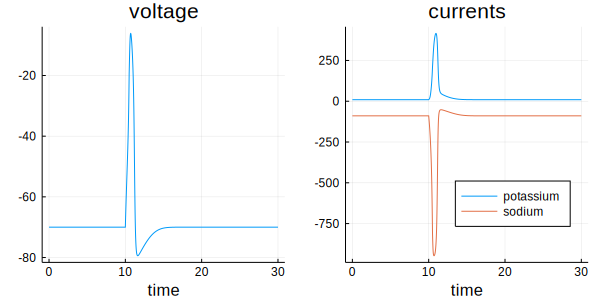

In [53]:
fig_a = plot(_t_preview, _trace.voltage, 
    legend=nothing, title="voltage", xlabel="time")

plot(_t_preview, _trace.potassium, label="potassium")
plot!(_t_preview, _trace.sodium, label="sodium")
fig_b = plot!(title="currents", legend=:bottomright, xlabel="time")

plot(fig_a, fig_b, size=(600, 300))